In [1]:
import pickle
import numpy as np
from tensorflow import keras
import pandas as pd
import os, datetime
from utils import data_read_dict, data_read_concat, data_merge
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.0


In [2]:
import platform
if platform.node() == "msbq":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())
    print(tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    tf.config.list_physical_devices('GPU')
    !python --version

## Hyperparameter

In [3]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Data

In [4]:
FXSpot_path = '../data/10min Dataset Spot.csv'

df = pd.read_csv(FXSpot_path, delimiter=';')

df.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
df['Dates'] = pd.to_datetime(df['Dates'], format='%d.%m.%y %H:%M')
df.sort_values('Dates', inplace=True)
df.sort_values('Dates')
df.index = df['Dates']
df

,Dates,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,...,GBPCHF BGNE Curncy Bid Open,GBPCHF BGNE Curncy Bid Close,GBPCHF BGNE Curncy Bid High,GBPCHF BGNE Curncy Bid Low,GBPCHF BGNE Curncy Bid Number Ticks,GBPCHF BGNE Curncy Ask Open,GBPCHF BGNE Curncy Ask Close,GBPCHF BGNE Curncy Ask High,GBPCHF BGNE Curncy Ask Low,GBPCHF BGNE Curncy Ask Number Ticks
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,2020-10-01 00:00:00,1.17231,1.17281,1.17290,1.17215,1264,1.17250,1.17291,1.17298,1.17234,...,1.18832,1.18985,1.18997,1.18832,1099,1.19030,1.19018,1.19043,1.18961,1099
2020-10-01 00:10:00,2020-10-01 00:10:00,1.17281,1.17280,1.17287,1.17264,1269,1.17292,1.17288,1.17296,1.17275,...,1.18991,1.19015,1.19015,1.18954,964,1.19016,1.19032,1.19045,1.18988,964
2020-10-01 00:20:00,2020-10-01 00:20:00,1.17278,1.17300,1.17305,1.17277,1380,1.17289,1.17308,1.17314,1.17286,...,1.19008,1.19004,1.19022,1.18969,1010,1.19038,1.19030,1.19050,1.19002,1010
2020-10-01 00:30:00,2020-10-01 00:30:00,1.17300,1.17303,1.17307,1.17298,1330,1.17308,1.17311,1.17314,1.17307,...,1.18999,1.18990,1.19013,1.18980,981,1.19028,1.19021,1.19041,1.19009,981
2020-10-01 00:40:00,2020-10-01 00:40:00,1.17303,1.17297,1.17309,1.17283,1351,1.17311,1.17309,1.17317,1.17290,...,1.18991,1.18981,1.19000,1.18970,1004,1.19010,1.19014,1.19029,1.18998,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 23:10:00,2021-03-22 23:10:00,1.19315,1.19339,1.19348,1.19313,952,1.19326,1.19348,1.19355,1.19320,...,1.28009,1.28019,1.28041,1.28001,1089,1.28037,1.28037,1.28064,1.28025,1089
2021-03-22 23:20:00,2021-03-22 23:20:00,1.19338,1.19327,1.19343,1.19326,958,1.19349,1.19337,1.19351,1.19332,...,1.28016,1.28008,1.28020,1.27998,899,1.28043,1.28032,1.28048,1.28021,899
2021-03-22 23:30:00,2021-03-22 23:30:00,1.19327,1.19330,1.19344,1.19320,1002,1.19336,1.19333,1.19350,1.19325,...,1.28005,1.27972,1.28020,1.27965,1139,1.28032,1.27994,1.28042,1.27987,1139


In [5]:
'''Calculate percentage change for FX Spot Rates'''
df = df.set_index('Dates')
df = df.pct_change()
df

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,GBPCHF BGNE Curncy Bid Open,GBPCHF BGNE Curncy Bid Close,GBPCHF BGNE Curncy Bid High,GBPCHF BGNE Curncy Bid Low,GBPCHF BGNE Curncy Bid Number Ticks,GBPCHF BGNE Curncy Ask Open,GBPCHF BGNE Curncy Ask Close,GBPCHF BGNE Curncy Ask High,GBPCHF BGNE Curncy Ask Low,GBPCHF BGNE Curncy Ask Number Ticks
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:10:00,0.000427,-0.000009,-0.000026,0.000418,0.003956,0.000358,-0.000026,-0.000017,0.000350,0.003956,...,0.001338,0.000252,0.000151,0.001027,-0.122839,-0.000118,0.000118,0.000017,0.000227,-0.122839
2020-10-01 00:20:00,-0.000026,0.000171,0.000153,0.000111,0.087470,-0.000026,0.000171,0.000153,0.000094,0.087470,...,0.000143,-0.000092,0.000059,0.000126,0.047718,0.000185,-0.000017,0.000042,0.000118,0.047718
2020-10-01 00:30:00,0.000188,0.000026,0.000017,0.000179,-0.036232,0.000162,0.000026,0.000000,0.000179,-0.036232,...,-0.000076,-0.000118,-0.000076,0.000092,-0.028713,-0.000084,-0.000076,-0.000076,0.000059,-0.028713
2020-10-01 00:40:00,0.000026,-0.000051,0.000017,-0.000128,0.015789,0.000026,-0.000017,0.000026,-0.000145,0.015789,...,-0.000067,-0.000076,-0.000109,-0.000084,0.023445,-0.000151,-0.000059,-0.000101,-0.000092,0.023445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 23:10:00,-0.000176,0.000184,-0.000025,0.000008,-0.060217,-0.000243,0.000193,-0.000075,0.000000,-0.060217,...,0.000618,0.000133,0.000133,0.000751,-0.043058,0.000539,-0.000055,0.000125,0.000516,-0.043058
2021-03-22 23:20:00,0.000193,-0.000101,-0.000042,0.000109,0.006303,0.000193,-0.000092,-0.000034,0.000101,0.006303,...,0.000055,-0.000086,-0.000164,-0.000023,-0.174472,0.000047,-0.000039,-0.000125,-0.000031,-0.174472
2021-03-22 23:30:00,-0.000092,0.000025,0.000008,-0.000050,0.045929,-0.000109,-0.000034,-0.000008,-0.000059,0.045929,...,-0.000086,-0.000281,0.000000,-0.000258,0.266963,-0.000086,-0.000297,-0.000047,-0.000266,0.266963


In [6]:
FX_Fundamentals_path = '../data/10min Dataset Rest.csv'

df2 = pd.read_csv(FX_Fundamentals_path, delimiter=';')

df2.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
df2.drop('UXA1 Comdty Trade Open', axis=1, inplace=True)
df2['Dates'] = pd.to_datetime(df2['Dates'], format='%d.%m.%y %H:%M')
df2.sort_values('Dates', inplace=True)
df2.sort_values('Dates')
df2.index = df2['Dates']
df2

,Dates,EURUSDV1M Curncy 44278 Open,USDJPYV1M Curncy Open,GBPUSDV1M Curncy Open,AUDUSDV1M Curncy Open,USDCADV1M Curncy Open,USDCHFV1M Curncy Open,NZDUSDV1M Curncy Open,EURJPYV1M Curncy Open,GBPJPYV1M Curncy Open,...,G 1 Comdty Trade Open,UB1 Comdty Trade Open,FF1 Comdty Trade Open,OE1 Comdty Trade Open,TU1 Comdty Trade Open,KE1 Comdty Trade Open,DU1 Comdty Trade Open,UXY1 Comdty Trade Open,CN1 Comdty Trade Open,KAA1 Comdty Trade Open
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,2020-10-01 00:00:00,6.5400,5.7075,10.6950,10.2450,6.2325,6.1150,9.6750,7.1125,10.8775,...,136.56,223.82,99.9150,135.28,110.480469,112.08,112.305,159.921875,152.26,133.12
2020-10-01 00:10:00,2020-10-01 00:10:00,6.5400,5.7150,10.6950,10.2450,6.2375,6.0975,9.6750,7.1125,10.8775,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.750000,152.26,133.12
2020-10-01 00:20:00,2020-10-01 00:20:00,6.5400,5.7100,10.6950,10.2500,6.2375,6.0950,9.6750,7.1125,10.8775,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.750000,152.26,133.12
2020-10-01 00:30:00,2020-10-01 00:30:00,6.5375,5.7125,10.7000,10.2500,6.2375,6.0950,9.6750,7.1125,10.8800,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.750000,152.26,133.12
2020-10-01 00:40:00,2020-10-01 00:40:00,6.4925,5.7125,10.7025,10.1425,6.2400,6.0400,9.6675,7.1125,10.8825,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.734375,152.26,133.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 23:10:00,2021-03-22 23:10:00,6.0575,5.7675,7.6400,10.0000,7.2025,6.5375,10.0425,6.2475,8.0925,...,128.55,205.64,99.9300,135.19,110.437500,110.81,112.125,144.468750,140.89,126.25
2021-03-22 23:20:00,2021-03-22 23:20:00,6.0600,5.7825,7.6500,10.0000,7.1975,6.5375,10.0425,6.2600,8.0950,...,128.55,205.64,99.9300,135.19,110.437500,110.81,112.125,144.531250,140.89,126.25
2021-03-22 23:30:00,2021-03-22 23:30:00,6.0575,5.7825,7.6500,10.0000,7.2000,6.5375,10.0425,6.2600,8.0975,...,128.55,205.64,99.9300,135.19,110.437500,110.81,112.125,144.531250,140.89,126.25


In [7]:
df_metrics = data_merge(data_read_dict('../data/bbg/'))
df_metrics.shape
df_metrics

,audcad___ATR,audcad___BB_MA,audcad___BB_UPPER,audcad___BB_LOWER,audcad___BB_WIDTH,audcad___BB_PERCENT,audcad___CMCI,audcad___DMI_PLUS,audcad___DMI_MINUS,audcad___ADX,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01 19:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01 19:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01 19:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01 19:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104.551111,NaN,104.553333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 23:10:00,0.000801,0.955120,0.957018,0.953222,0.397437,0.310327,4.669540,18.297082,21.744603,44.859017,...,66.666667,61.102564,72.394872,76.555311,110.705027,NaN,110.725556,110.720461,110.731333,-33.333333
2021-03-31 23:20:00,0.000634,0.955000,0.956756,0.953244,0.367776,0.329170,-11.057108,17.583296,20.896326,42.269789,...,33.333333,52.769231,66.424908,71.918681,110.705027,NaN,110.726667,110.720445,110.728000,-66.666667
2021-03-31 23:30:00,0.000656,0.954860,0.956424,0.953296,0.327554,0.257009,-37.551583,16.013532,22.856898,40.508060,...,44.444444,49.658120,60.480342,66.433374,110.705027,NaN,110.731111,110.720711,110.729333,-55.555556


In [8]:
df3 = pd.merge(df, df2, left_index=True, right_index=True)
df3['Dates'] = pd.to_datetime(df3['Dates'], format='%d.%m.%y %H:%M')
df3.index = df3['Dates']
df3

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,G 1 Comdty Trade Open,UB1 Comdty Trade Open,FF1 Comdty Trade Open,OE1 Comdty Trade Open,TU1 Comdty Trade Open,KE1 Comdty Trade Open,DU1 Comdty Trade Open,UXY1 Comdty Trade Open,CN1 Comdty Trade Open,KAA1 Comdty Trade Open
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136.56,223.82,99.9150,135.28,110.480469,112.08,112.305,159.921875,152.26,133.12
2020-10-01 00:10:00,0.000427,-0.000009,-0.000026,0.000418,0.003956,0.000358,-0.000026,-0.000017,0.000350,0.003956,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.750000,152.26,133.12
2020-10-01 00:20:00,-0.000026,0.000171,0.000153,0.000111,0.087470,-0.000026,0.000171,0.000153,0.000094,0.087470,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.750000,152.26,133.12
2020-10-01 00:30:00,0.000188,0.000026,0.000017,0.000179,-0.036232,0.000162,0.000026,0.000000,0.000179,-0.036232,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.750000,152.26,133.12
2020-10-01 00:40:00,0.000026,-0.000051,0.000017,-0.000128,0.015789,0.000026,-0.000017,0.000026,-0.000145,0.015789,...,136.56,223.82,99.9175,135.28,110.468750,112.08,112.305,159.734375,152.26,133.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 23:10:00,-0.000176,0.000184,-0.000025,0.000008,-0.060217,-0.000243,0.000193,-0.000075,0.000000,-0.060217,...,128.55,205.64,99.9300,135.19,110.437500,110.81,112.125,144.468750,140.89,126.25
2021-03-22 23:20:00,0.000193,-0.000101,-0.000042,0.000109,0.006303,0.000193,-0.000092,-0.000034,0.000101,0.006303,...,128.55,205.64,99.9300,135.19,110.437500,110.81,112.125,144.531250,140.89,126.25
2021-03-22 23:30:00,-0.000092,0.000025,0.000008,-0.000050,0.045929,-0.000109,-0.000034,-0.000008,-0.000059,0.045929,...,128.55,205.64,99.9300,135.19,110.437500,110.81,112.125,144.531250,140.89,126.25


In [9]:
df_merged = pd.merge(df3, df_metrics, left_index=True, right_index=True, how='outer')
df_merged = df_merged.loc[df_merged.index <= max(df3.Dates),:]
df = df_merged[:]
df = df.set_index('Dates')
df

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:10:00,0.000427,-0.000009,-0.000026,0.000418,0.003956,0.000358,-0.000026,-0.000017,0.000350,0.003956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:20:00,-0.000026,0.000171,0.000153,0.000111,0.087470,-0.000026,0.000171,0.000153,0.000094,0.087470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:30:00,0.000188,0.000026,0.000017,0.000179,-0.036232,0.000162,0.000026,0.000000,0.000179,-0.036232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:40:00,0.000026,-0.000051,0.000017,-0.000128,0.015789,0.000026,-0.000017,0.000026,-0.000145,0.015789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 23:10:00,-0.000176,0.000184,-0.000025,0.000008,-0.060217,-0.000243,0.000193,-0.000075,0.000000,-0.060217,...,42.857143,77.142857,89.367965,91.595516,108.802835,NaN,108.835556,108.811932,108.828000,-80.000000
2021-03-22 23:20:00,0.000193,-0.000101,-0.000042,0.000109,0.006303,0.000193,-0.000092,-0.000034,0.000101,0.006303,...,42.857143,65.714286,83.318903,88.484848,108.802835,NaN,108.826667,108.811868,108.820000,-80.000000
2021-03-22 23:30:00,-0.000092,0.000025,0.000008,-0.000050,0.045929,-0.000109,-0.000034,-0.000008,-0.000059,0.045929,...,28.571429,54.285714,75.555556,82.747475,NaN,108.860237,108.816667,108.811405,108.811333,-100.000000


Filling missing values by last known values and dropping all lines with missing values (only earlier values).

In [10]:
df = df.iloc[::-1, :].bfill().iloc[::-1, :]
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values"
set(np.diff(df.index.values))

{numpy.timedelta64(600000000000,'ns')}

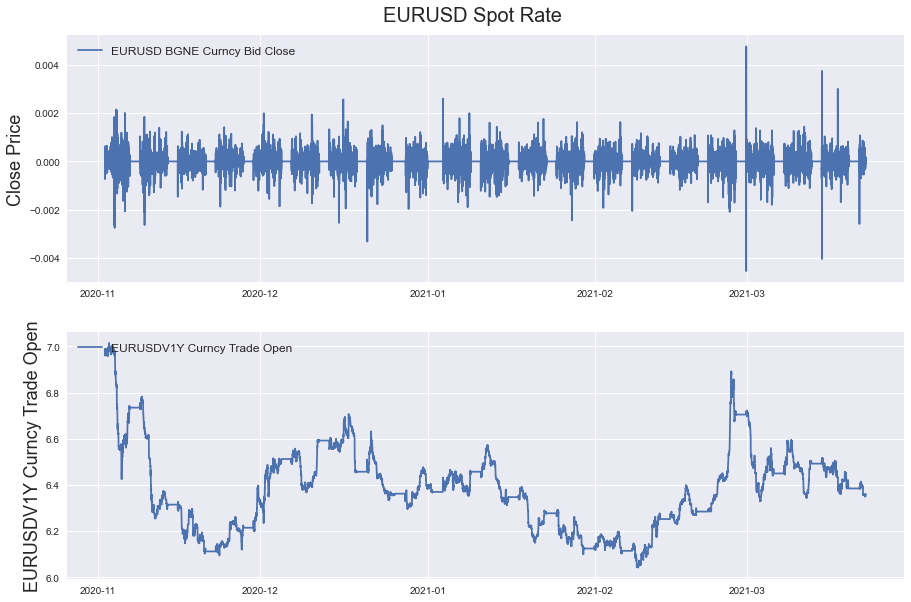

In [11]:
'''Plot data'''
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("EURUSD Spot Rate", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['EURUSD BGNE Curncy Bid Close'], label='EURUSD BGNE Curncy Bid Close')
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['EURUSDV1Y Curncy Trade Open'], label='EURUSDV1Y Curncy Trade Open')
ax2.set_ylabel('EURUSDV1Y Curncy Trade Open', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [12]:
'''Normalize data'''
df = (df - df.mean()) / (df.max() - df.min())
df.columns[np.isnan(df).any(axis=0)]

Index([], dtype='object')

## Create training, validation and test split

In [13]:
# df = df.iloc[:2500,]
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Convert pandas columns into arrays
train_data = df_train.values
train_data_dates = df_train.index.values  # !!!NEW
val_data = df_val.values
val_data_dates = df_val.index.values  # !!!NEW
test_data = df_test.values
test_data_dates = df_test.index.values  # !!!NEW
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (16204, 1273)
Validation data shape: (2025, 1273)
Test data shape: (2025, 1273)


,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-02 08:20:00,-0.009618,-0.010311,0.007228,-0.008858,-0.000262,-0.009539,-0.011536,0.003452,-0.015719,-0.000262,...,0.524181,0.289807,0.208371,0.191208,-0.035290,-0.052061,-0.027283,-0.031085,-0.026090,0.526556
2020-11-02 08:30:00,-0.010566,-0.063962,-0.038460,-0.060348,-0.000082,-0.010480,-0.065669,-0.026133,-0.107122,-0.000082,...,0.524181,0.356473,0.240315,0.210474,-0.033624,-0.052061,-0.025788,-0.030546,-0.024394,0.526556
2020-11-02 08:40:00,-0.065547,0.060949,-0.002651,0.005108,0.000156,-0.065009,0.060675,-0.001927,0.010622,0.000156,...,0.447258,0.391089,0.283183,0.243551,-0.032007,-0.052061,-0.023795,-0.029771,-0.022199,0.449633
2020-11-02 08:50:00,0.056768,-0.078764,0.010936,-0.034185,-0.000629,0.058184,-0.079917,0.007937,-0.060679,-0.000629,...,0.465358,0.429324,0.334590,0.285967,-0.030513,-0.052061,-0.021138,-0.028633,-0.018606,0.467733
2020-11-02 09:00:00,-0.077875,0.010045,-0.094046,-0.015854,0.000048,-0.078176,0.008413,-0.068283,-0.026588,0.000048,...,0.524181,0.469324,0.386622,0.335133,-0.027380,-0.052061,-0.017982,-0.027149,-0.015513,0.526556


## Plot daily changes of close prices and volatility

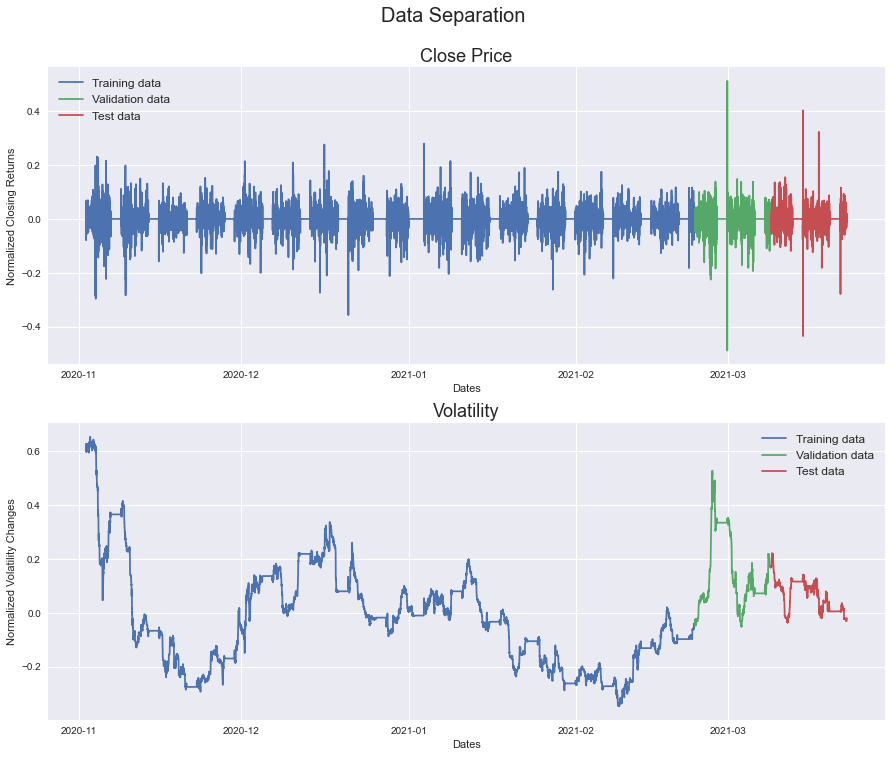

In [14]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(train_data_dates, df_train['EURUSD BGNE Curncy Bid Close'], label='Training data')  # !!!NEW
ax1.plot(val_data_dates, df_val['EURUSD BGNE Curncy Bid Close'], label='Validation data')  # !!!NEW
ax1.plot(test_data_dates, df_test['EURUSD BGNE Curncy Bid Close'], label='Test data')  # !!!NEW
ax1.set_xlabel('Dates')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(train_data_dates, df_train['EURUSDV1Y Curncy Trade Open'], label='Training data')  # !!!NEW
ax2.plot(val_data_dates, df_val['EURUSDV1Y Curncy Trade Open'], label='Validation data')  # !!!NEW
ax2.plot(test_data_dates, df_test['EURUSDV1Y Curncy Trade Open'], label='Test data')  # !!!NEW
ax2.set_xlabel('Dates')
ax2.set_ylabel('Normalized Volatility Changes')
ax2.set_title("Volatility", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [15]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (16076, 128, 1273) (16076,)
Validation set shape (1897, 128, 1273) (1897,)
Testing set shape (1897, 128, 1273) (1897,)


## TimeVector

In [16]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config
  

## Transformer

In [17]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k, 
                         input_shape=input_shape, 
                         kernel_initializer='glorot_uniform', 
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out    

#############################################################################

class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  

        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config          

## Model

In [ ]:
def create_model(input_shape):
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, input_shape))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
#   x = Concatenate(axis=-1)([Dense(64)(in_seq), x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mape'])
  return model


model = create_model(df.shape[1])
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('../content/Transformer+TimeEmbedding{epoch}.hdf5', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, verbose=1
                                             )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


if True: 
    history = model.fit(X_train, y_train,
                        batch_size=batch_size, 
                        epochs=2, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
    with open('../content/history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
# else    
#    model.save(.h5)
#    model.load

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1273)]  0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 1275)    0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 1275)    16337122    concatenate[0][0]            

In [ ]:
model_last = sorted([i for i in os.listdir('../content') if 'hdf5' in i and 'Transformer+TimeEmbedding' in i])[-1]

In [ ]:
model = tf.keras.models.load_model(
    os.path.join('../content', model_last),
    custom_objects={
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
with open('../content/history.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

In [ ]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data_dates, train_data[:, 3], label='EURUSD Closing Returns')
ax11.plot(train_data_dates[seq_len:], train_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Dates')
ax11.set_ylabel('EURUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data_dates, val_data[:, 3], label='EURUSD Closing Returns')
ax21.plot(val_data_dates[seq_len:], val_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Dates')
ax21.set_ylabel('EURUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data_dates, test_data[:, 3], label='EURUSD Closing Returns')
ax31.plot(test_data_dates[seq_len:], test_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Dates')
ax31.set_ylabel('EURUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history['loss'], label='Training loss (MSE)')
ax1.plot(history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history['mae'], label='Training MAE')
ax2.plot(history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history['mape'], label='Training MAPE')
ax3.plot(history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="EURUSD_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)